In [2]:
# Essentials
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm
import matplotlib.ticker as ticker
from matplotlib import patches
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import gaussian_kde

#### Downloading the xml metadata file

In [4]:
import requests

url = 'https://data.piscoweb.org/metacat/d1/mn/v2/object/urn:uuid:f22f1cb1-0aae-4506-890a-3d9125d9b3e2'
response = requests.get(url)
with open('stillwater-PISCO-ADCP.xml', 'wb') as f:
    f.write(response.content)

### Load data from txt file 

[Here is the link to the data] (https://search.dataone.org/view/doi%3A10.6085%2FC3H597#urn%3Auuid%3Af22f1cb1-0aae-4506-890a-3d9125d9b3e2)

In [7]:
# Load ADCP dataset
adcp1 = pd.read_csv("/Users/jessicafranks/grad_school/grad_thesis/thesis-python/dispersal-model/ADCP-data/PISCO-adcp/PISCO-SWC-ADCP.txt", sep=r'\s+', header = 0)
#what does the time variable look like?
adcp1.time

0         20:39:33.00Z
1         20:39:33.00Z
2         20:39:33.00Z
3         20:39:33.00Z
4         20:39:33.00Z
              ...     
574933    22:04:33.00Z
574934    22:04:33.00Z
574935    22:04:33.00Z
574936    22:04:33.00Z
574937    22:04:33.00Z
Name: time, Length: 574938, dtype: object

In [8]:
# Convert 'time' column to datetime with UTC timezone handling
adcp1['time'] = pd.to_datetime(adcp1['time'], utc=True)

# Apply quality control filter
qc_mask = (adcp1.flag == 0) & (adcp1.eatward != 9999) & (adcp1.northward != 9999)
adcp1_qc = adcp1[qc_mask]

# Select numeric columns to average
numeric_cols = ['eatward', 'northward']

# Group and average over time and depth
adcp1_qc_agg = adcp1_qc.groupby(['time', 'depth'])[numeric_cols].mean().reset_index()

# Sort and prepare for interpolation
time_values = pd.DatetimeIndex(adcp1_qc_agg['time'].unique())
time_values = time_values.sort_values()
bindist = np.sort(adcp1_qc_agg['depth'].unique())

time_sec = (time_values - time_values[0]) / np.timedelta64(1, 's')
adcp_duration_sec = time_sec[-1] # total duration of ADCP data in seconds

# Pivot to 2D arrays for interpolation
u_data = adcp1_qc_agg.pivot(index='time', columns='depth', values='eatward').loc[time_values, bindist].values
v_data = adcp1_qc_agg.pivot(index='time', columns='depth', values='northward').loc[time_values, bindist].values

# Create interpolators
u_interp = RegularGridInterpolator((time_sec, bindist), u_data, bounds_error=False, fill_value=0)
v_interp = RegularGridInterpolator((time_sec, bindist), v_data, bounds_error=False, fill_value=0)

/var/folders/t6/9mj5h_qd17d697_8bs8tsr2c0000gn/T/ipykernel_22143/54111634.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adcp1['time'] = pd.to_datetime(adcp1['time'], utc=True)


**Setting up some parameters**

In [10]:
kv = 1.22e-6 # m^2/s^-1 this is the kinematic velocity of seawater (Grady 2024)
diameter = 0.3 #meters
# Grady 2024
max_current = 0.025 # m/s
min_current = 0.007 # m/s
re = (max_current * diameter) / kv # to be calculated later once I get diameter values for stephy in the field 

In [11]:
n_particles = 500
release_height = 0.5 #meters
plant_depth = 21 #meters
sinking_speeds = [0.0009020192] # m/s
bottom_roughness = 0.08 # meters
Kz = 1e-4
dt = 1000
settle_fraction = 0.9

wave_height = 0.23 # meters (grady 2024)
wave_period = 7.4 #second (grady 2024)
g = 9.81

L = (g * wave_period**2) / (2 * np.pi) * np.tanh((2 * np.pi * plant_depth) / (wave_period**2 * g))
k = 2 * np.pi / L
U_s = (np.pi * wave_height**2) / (2 * wave_period * np.sinh(k * plant_depth)**2)

def stokes_drift(z):
    return U_s * np.exp(-2 * k * z)

**Defining the particle class**

In [13]:
# Propagule definitions
class Particle:
    def __init__(self, z=release_height):
        self.x = 0.0
        self.y = 0.0
        self.z = z
        self.settled = False

#### Creating the simulation function

In [15]:
# Run simulation Function
def run_simulation(release_height, plant_depth, sinking_speeds):
    particles = [Particle(z=release_height) for _ in range(n_particles)]
    positions = []
    t = 0
    settled_count = 0

    #run for 50 days instead of full ADCP time (based on zygote viability)
    max_simulation_time_sec = 50 * 24 * 60 * 60 # 50 days in seconds
    max_time_steps = int(max_simulation_time_sec / dt)
    
    while settled_count < settle_fraction * n_particles and t < max_time_steps:
        t_sec = (t * dt) % adcp_duration_sec # loop the ADCP data so it can run for the full 50 days
        settled_count = 0
        current_positions = []

        for p in particles:
            if not p.settled:
                u = u_interp((t_sec, p.z))
                v = v_interp((t_sec, p.z))
                u += stokes_drift(p.z)

                p.x += u * dt
                p.y += v * dt

                dz_sink = sinking_speeds * dt
                dz_diff = np.random.normal(0, np.sqrt(2 * Kz * dt))
                p.z -= dz_sink
                p.z += dz_diff

                if p.z <= bottom_roughness:
                    p.z = 0
                    p.settled = True
                    settled_count += 1

            current_positions.append((p.x, p.y, p.z))

        positions.append(current_positions)
        t += 1

    return np.array(positions[-1]) if positions else np.array([])

#### Running it

In [17]:
# Run simulations
release_heights = np.arange(0.5, 21.0, 0.05) #from 50 cm to just below 12m, every 5 cm
plant_depths = [12.0]
sinking_speeds = 0.0009020192

all_particles = []

for r in release_heights:
    final_positions = run_simulation(release_height=r, plant_depth=plant_depth, sinking_speeds=sinking_speeds)
    if len(final_positions) > 0:
        release_column = np.full((final_positions.shape[0], 1), r)
        final_with_release = np.hstack((final_positions, release_column))  # columns: x, y, z, release_height
        all_particles.append(final_with_release)

In [18]:
all_particles = np.vstack(all_particles)
x, y, z, release_h = all_particles[:, 0], all_particles[:, 1], all_particles[:, 2], all_particles[:, 3]

### Plotting

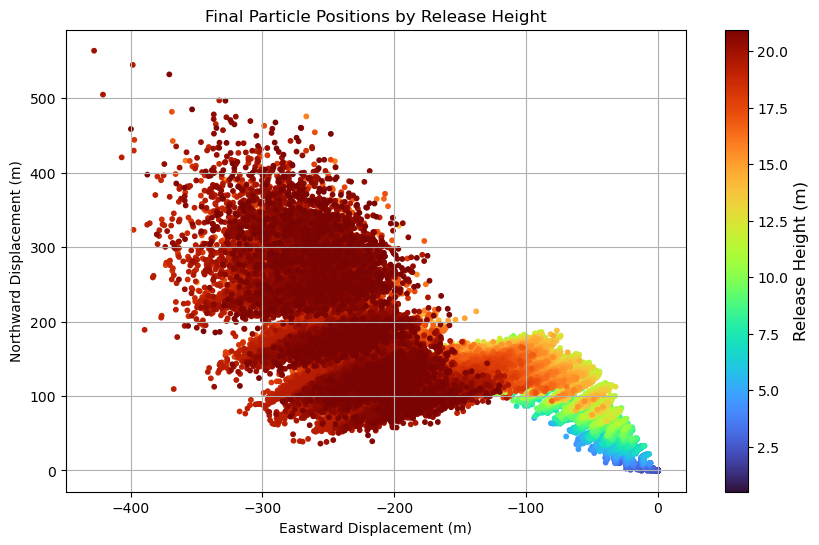

In [50]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=release_h, cmap='turbo', s=10)  # 'turbo' or 'viridis' are good for heatmaps
cbar = plt.colorbar(scatter)
cbar.set_label("Release Height (m)", fontsize=12)

plt.xlabel("Eastward Displacement (m)")
plt.ylabel("Northward Displacement (m)")
plt.title("Final Particle Positions by Release Height")
plt.grid(True)
plt.savefig("figures/displacementVSrelease-PISCO.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()


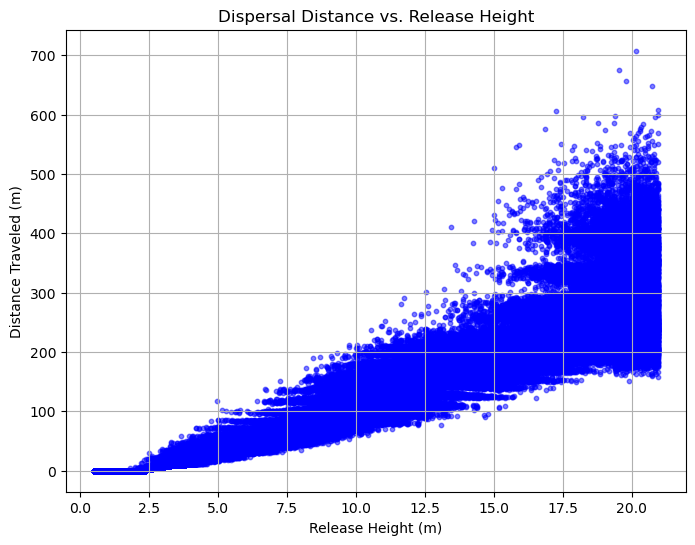

In [51]:
distance = np.sqrt(x**2 + y**2)

plt.figure(figsize=(8, 6))
plt.scatter(release_h, distance, alpha=0.5, s=10, c='blue')  # Optional: use c=distance, cmap='viridis' for gradient

plt.xlabel("Release Height (m)")
plt.ylabel("Distance Traveled (m)")
plt.title("Dispersal Distance vs. Release Height")
plt.grid(True)
plt.savefig("figures/dispersaldistVSreleaseheight-PISCO.png", dpi=300, bbox_inches='tight')  # Save to current working dir
plt.show()

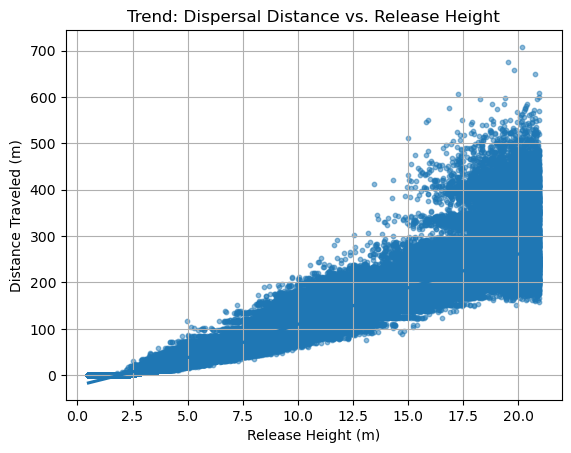

In [52]:
import seaborn as sns

sns.regplot(x=release_h, y=distance, scatter_kws={'s':10, 'alpha':0.5}, lowess=True)
plt.xlabel("Release Height (m)")
plt.ylabel("Distance Traveled (m)")
plt.title("Trend: Dispersal Distance vs. Release Height")
plt.grid(True)
plt.savefig("figures/all_releaseVSdistance-PISCO.png", dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()

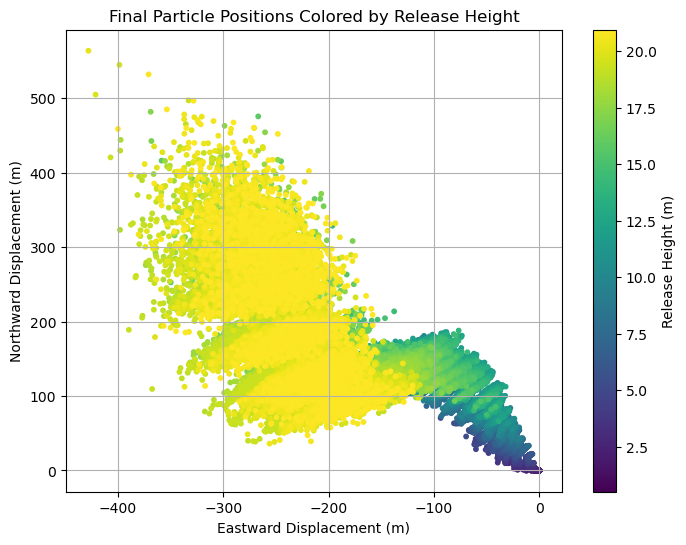

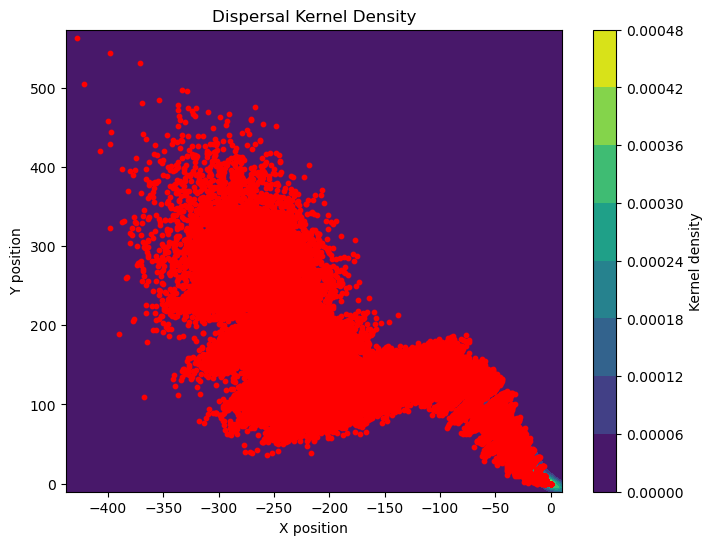

In [23]:
plant_depths = [21.0]
sinking_speeds = [0.0009020192]  # must be iterable

results = {}

for r in release_heights:
    for pd_val in plant_depths:
        for ss in sinking_speeds:
            label = f"r{r}_pd{pd_val}"
            trajectories = run_simulation(release_height=r, plant_depth=pd_val, sinking_speeds=ss)
            results[label] = trajectories

# Combine all final positions and label by release height
all_final_positions = []
release_labels = []

for r in release_heights:
    for pd_val in plant_depths:
        label = f"r{r}_pd{pd_val}"
        data = results.get(label)
        if data is not None and data.size > 0:
            all_final_positions.append(data)
            release_labels.extend([r] * data.shape[0])  # Tag with release height

# Stack all final positions into a single array
all_final_positions = np.vstack(all_final_positions)
release_labels = np.array(release_labels)

# Unpack x, y positions
x = all_final_positions[:, 0]
y = all_final_positions[:, 1]

# Plot final particle positions colored by release height
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=release_labels, cmap='viridis', s=10)
cbar = plt.colorbar(scatter, label="Release Height (m)")
plt.xlabel("Eastward Displacement (m)")
plt.ylabel("Northward Displacement (m)")
plt.title("Final Particle Positions Colored by Release Height")
plt.grid(True)
plt.show()

# Dispersal Kernel density

from scipy.stats import gaussian_kde

# Remove invalid points
mask = np.isfinite(x) & np.isfinite(y)
final_x = x[mask]
final_y = y[mask]

# KDE
xy = np.vstack([final_x, final_y])
kde = gaussian_kde(xy)

# Grid for KDE evaluation
xgrid, ygrid = np.meshgrid(
    np.linspace(final_x.min() - 10, final_x.max() + 10, 100),
    np.linspace(final_y.min() - 10, final_y.max() + 10, 100)
)
positions_kde = np.vstack([xgrid.ravel(), ygrid.ravel()])
density = kde(positions_kde).reshape(xgrid.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xgrid, ygrid, density, cmap='viridis')
plt.colorbar(label="Kernel density")
plt.scatter(final_x, final_y, c='red', s=10)
plt.title("Dispersal Kernel Density")
plt.xlabel("X position")
plt.ylabel("Y position")
plt.show()


#### **different types of plots - faceted**

/var/folders/t6/9mj5h_qd17d697_8bs8tsr2c0000gn/T/ipykernel_22143/1772667221.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_label, group) in enumerate(df_particles.groupby('release_bin')):


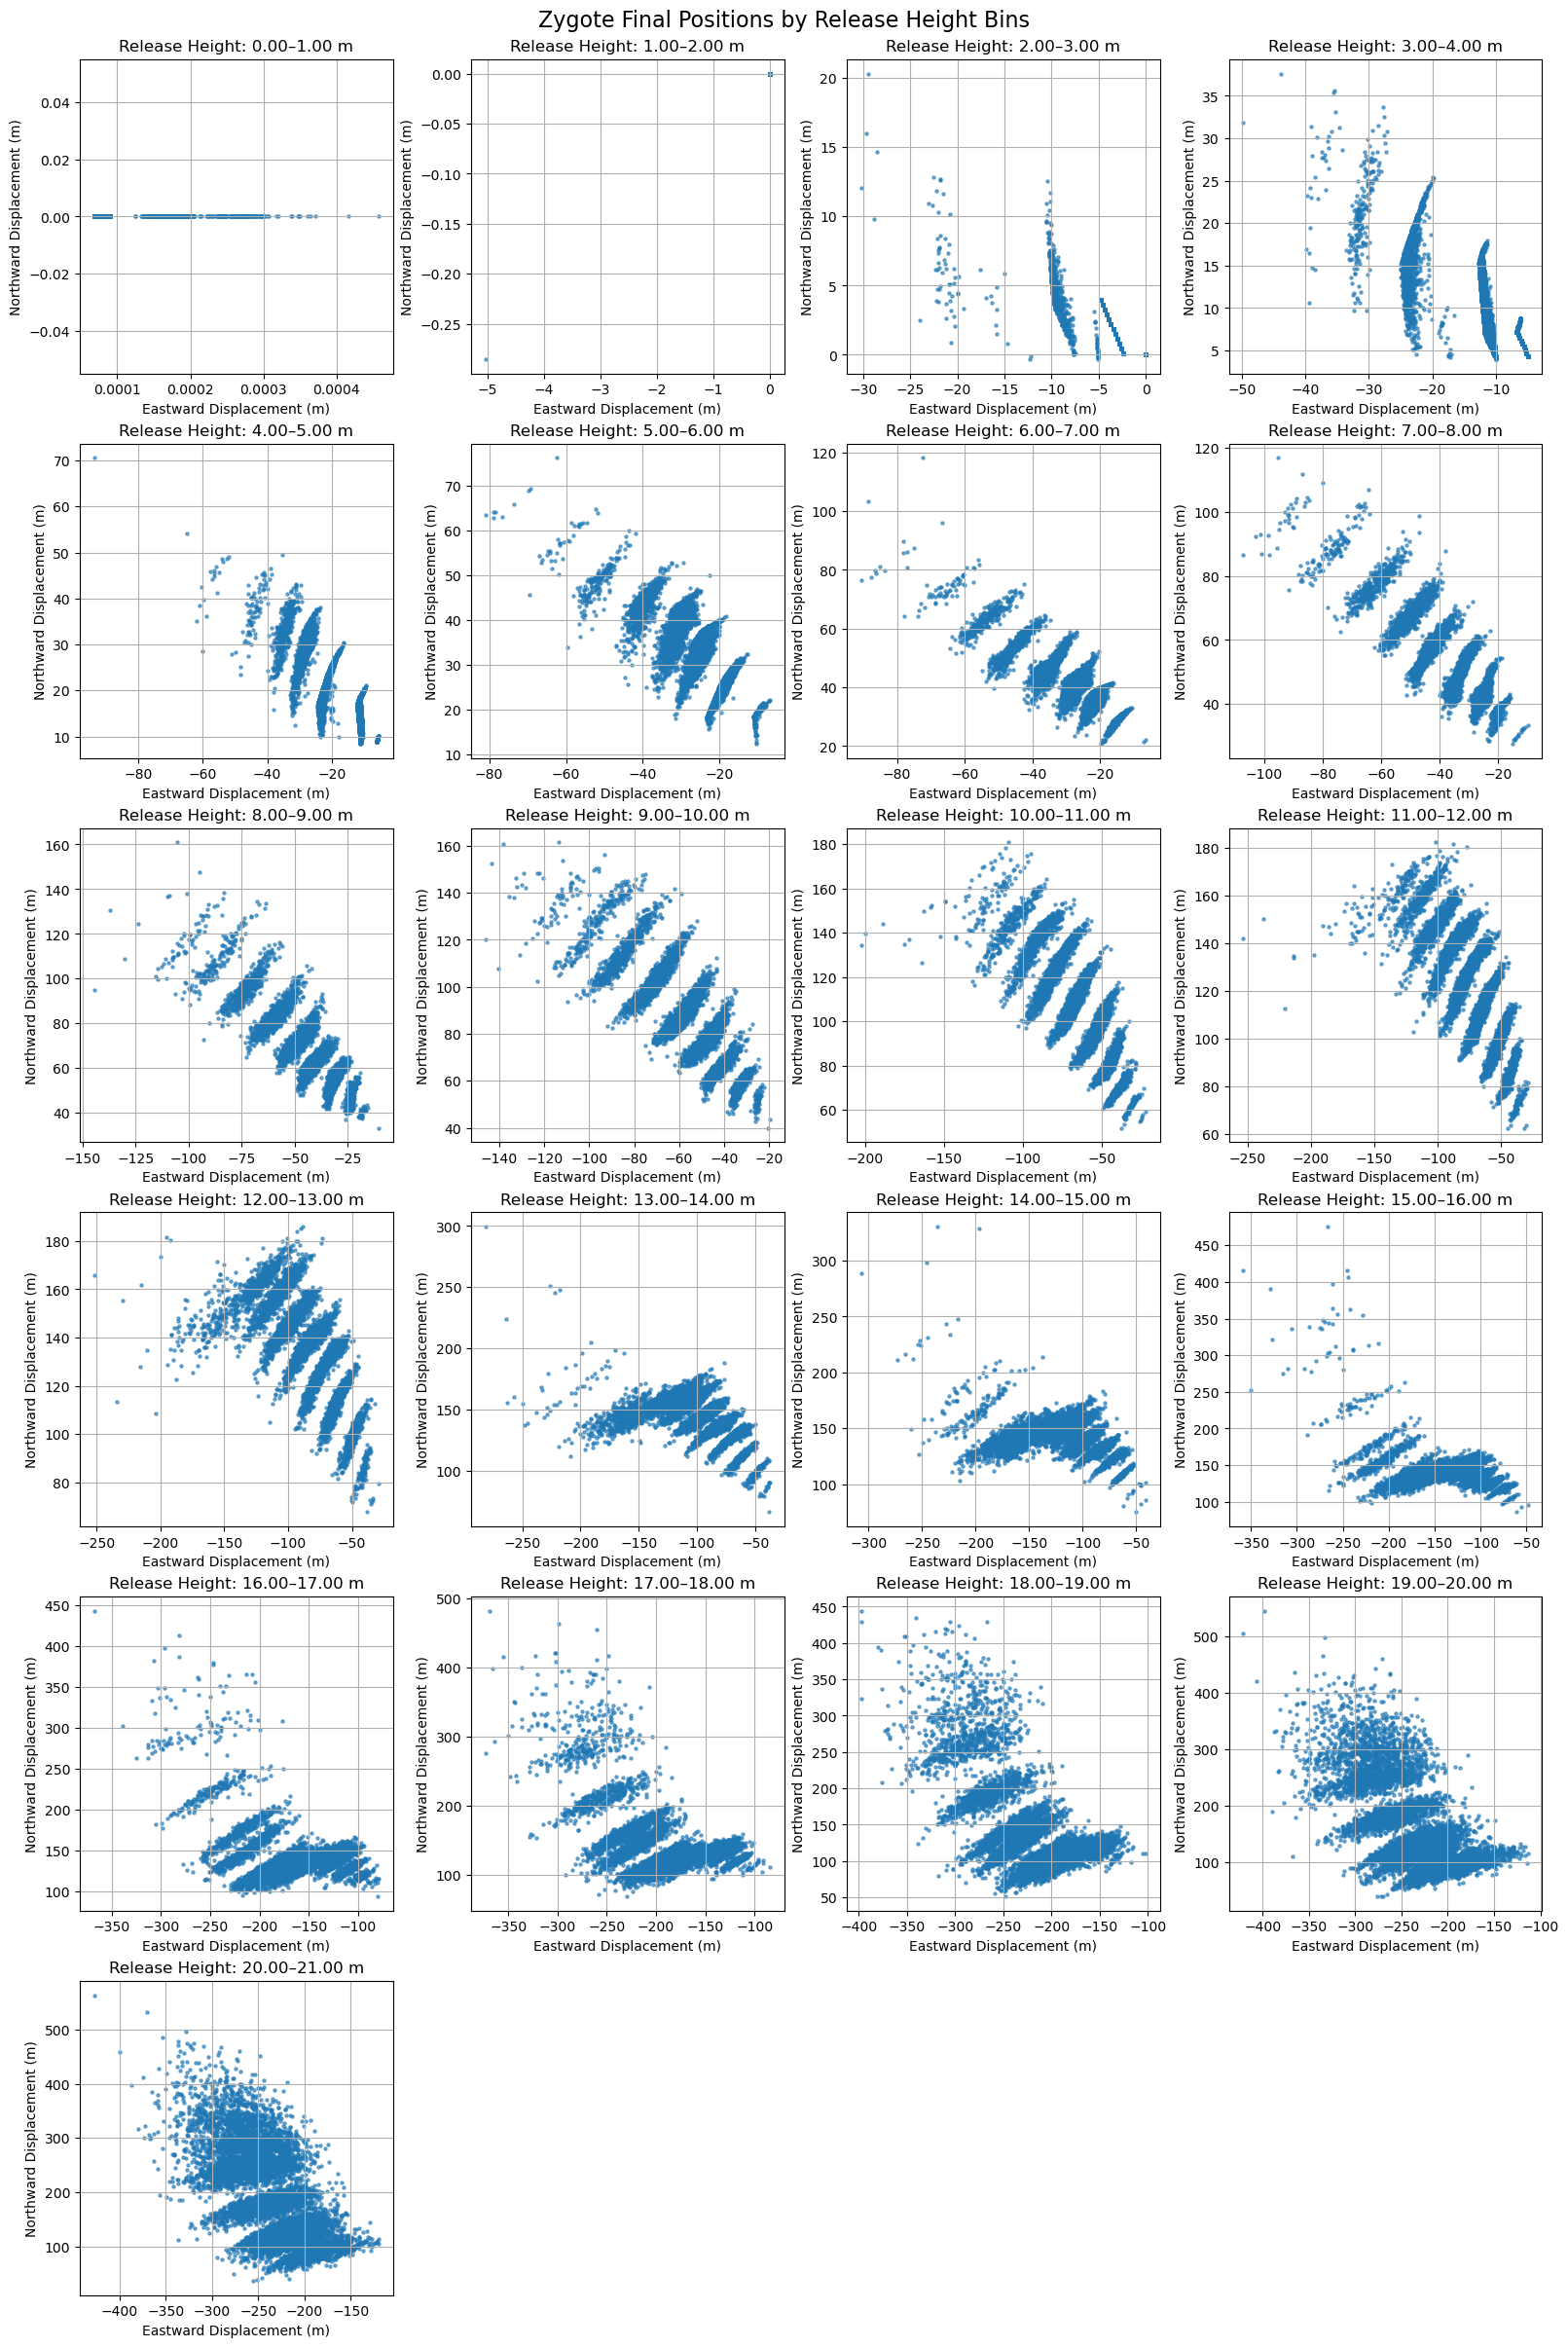

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame (replace with your actual data)
df_particles = pd.DataFrame({
    'x': x,
    'y': y,
    'release_height': release_h
})

# Define bins exactly as you want: 0.3-1, 1.05-2, 2.05-3, ...
start_heights = np.arange(0.0, 21.0, 1.0)
bin_ranges = [(start, start + 1) for start in start_heights]
bin_labels = [f"{low:.2f}–{high:.2f} m" for low, high in bin_ranges]

def assign_bin(height):
    for (low, high), label in zip(bin_ranges, bin_labels):
        if low <= height <= high:
            return label
    return np.nan

df_particles['release_bin'] = df_particles['release_height'].apply(assign_bin)
df_particles = df_particles.dropna(subset=['release_bin'])

# Make release_bin an ordered categorical dtype
df_particles['release_bin'] = pd.Categorical(
    df_particles['release_bin'],
    categories=bin_labels,
    ordered=True
)

# Prepare subplots layout
n_bins = len(bin_labels)
n_cols = 4
n_rows = int(np.ceil(n_bins / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Plot in correct order, grouped by the ordered categorical
for i, (bin_label, group) in enumerate(df_particles.groupby('release_bin')):
    ax = axes[i]
    ax.scatter(group['x'], group['y'], s=5, alpha=0.6)
    ax.set_title(f"Release Height: {bin_label}")
    ax.set_xlabel("Eastward Displacement (m)")
    ax.set_ylabel("Northward Displacement (m)")
    ax.grid(True)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Zygote Final Positions by Release Height Bins", fontsize=16)
plt.savefig("figures/faceted_displacement_ordered-PISCO.png", dpi=300, bbox_inches='tight')
plt.show()
